### PHYSICAL REVIEW LETTERS 122, 047702 (2019) results:

In [2]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


def ergotropy(rho, H):
    r = np.sort(rho.eigenenergies())[::-1]
    e = np.sort(H.eigenenergies())
    return qt.expect(H, rho) - np.sum(r * e)


def collective_ops(N):
    sp, sm, I = qt.sigmap(), qt.sigmam(), qt.qeye(2)
    Sp = qt.jmat(N/2,'+')
    Sm = Sp.dag()
    Sz = qt.jmat(N/2,'z')
    HB = Sz+N/2*qt.qeye(N+1)
    return Sp, Sm, HB


def simulate_N(N, kind):
    nmax = 20
    a = qt.destroy(nmax)

    Sp, Sm, HB = collective_ops(N)
    IB = qt.qeye(N+1)

    H = (qt.tensor(a.dag()*a, IB)
       + qt.tensor(qt.qeye(nmax), HB)
       + qt.tensor(a, Sp)
       + qt.tensor(a.dag(), Sm))

    if kind == "fock":
        psiA = qt.basis(nmax, N)
    elif kind == "coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif kind == "squeezed":
        psiA = qt.squeeze(nmax, np.arcsinh(np.sqrt(N))) * qt.basis(nmax, 0)

    psiB0 = qt.basis(N+1,N)
    psi0 = qt.tensor(psiA, psiB0)

    t = np.pi/np.sqrt(N)
    tlist = np.linspace(0,t,100)
    eops = qt.tensor(qt.qeye(nmax), HB)
    sol = qt.mesolve(H, psi0, tlist,e_ops=eops)
    Eblist = np.transpose(sol.expect).ravel()
    power = Eblist[1:-1]/tlist[1:-1]
    indx = np.argmax(power)
    t = tlist[indx]
    rho = qt.mesolve(H, psi0, [0, t]).states[-1]
    rhoB = rho.ptrace(1)
    
    return ergotropy(rhoB, HB) / qt.expect(HB, rhoB)

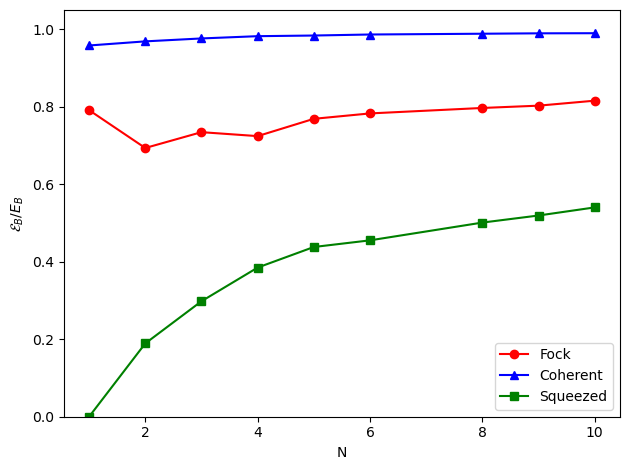

In [5]:
Ns = [1, 2, 3, 4, 5, 6, 8, 9, 10]
states = ["fock", "coherent", "squeezed"]

data = {s: [simulate_N(N, s) for N in Ns] for s in states}

plt.plot(Ns, data["fock"], "o-", color='red', label="Fock")
plt.plot(Ns, data["coherent"], "^-", color='blue', label="Coherent")
plt.plot(Ns, data["squeezed"], "s-",color='green', label="Squeezed")
plt.xlabel("N")
plt.ylabel(r"$\mathcal{E}_B / E_B$")
plt.legend(loc='lower right')
plt.tight_layout()
plt.ylim(0,1.05)
plt.show()

/var/folders/mz/8z6t7nxj1rzg2jvg9_6hk8km0000gn/T/ipykernel_27887/4073050246.py:63: RuntimeWarning: invalid value encountered in divide
  ratio = erg / EB


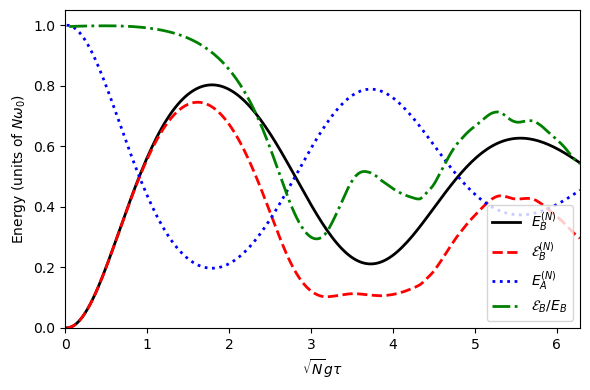

In [7]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# -----------------------
# Parameters
# -----------------------
N     = 9
j     = N/2
g     = 1.0
w0    = 1.0
nmax  = 20
tlist = np.linspace(0.005, 2*np.pi/np.sqrt(N), 200)

# -----------------------
# Operators
# -----------------------
a  = qt.destroy(nmax)
Sp = qt.jmat(j, '+')
Sm = Sp.dag()
Sz = qt.jmat(j, 'z')

HB = w0 * (Sz + j * qt.qeye(N+1))
HA = w0 * qt.tensor(a.dag()*a, qt.qeye(N+1))

H = (qt.tensor(a.dag()*a, qt.qeye(N+1))
     + qt.tensor(qt.qeye(nmax), HB)
     + g*(qt.tensor(a, Sp) + qt.tensor(a.dag(), Sm)))

# -----------------------
# Initial state
# -----------------------
psi0 = qt.tensor(qt.coherent(nmax, np.sqrt(N)),qt.basis(N+1, N))

# -----------------------
# Time evolution
# -----------------------
opts = qt.Options(store_states=True)
eops = [qt.tensor(qt.qeye(nmax), HB),qt.tensor(a.dag()*a, qt.qeye(N+1))]

sol = qt.mesolve(H, psi0, tlist, e_ops=eops, options=opts)

EB = np.real(sol.expect[0])
EA = np.real(sol.expect[1])

# -----------------------
# Ergotropy
# -----------------------
def ergotropy(rho, H):
    p = np.sort(rho.eigenenergies())[::-1]
    e = np.sort(H.eigenenergies())
    return qt.expect(H, rho) - np.sum(p*e)

erg = np.array([ergotropy(st.ptrace(1), HB) for st in sol.states])

# -----------------------
# Rescaled axes
# -----------------------
x     = np.sqrt(N) * g * tlist
EBs   = EB  / (N*w0)
EAs   = EA  / (N*w0)
ergs  = erg / (N*w0)
ratio = erg / EB

# -----------------------
# Plot (PRL Fig. 2)
# -----------------------
plt.figure(figsize=(6,4))
plt.plot(x, EBs,  'k-',  lw=2, label=r'$E_B^{(N)}$')
plt.plot(x, ergs, 'r--', lw=2, label=r'$\mathcal{E}_B^{(N)}$')
plt.plot(x, EAs,  'b:',  lw=2, label=r'$E_A^{(N)}$')
plt.plot(x, ratio,'g-.', lw=2, label=r'$\mathcal{E}_B/E_B$')

plt.xlabel(r'$\sqrt{N} g \tau$')
plt.ylabel(r'Energy (units of $N\omega_0$)')
plt.xlim(0, 2*np.pi)
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

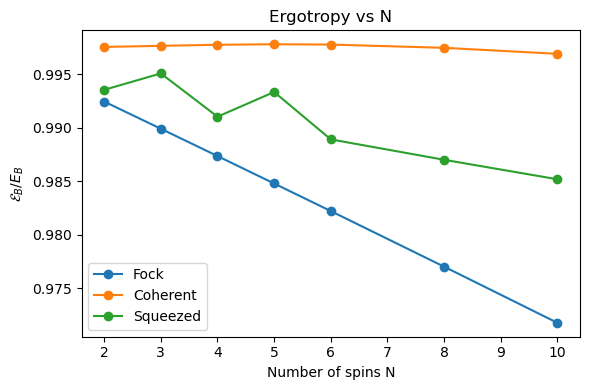

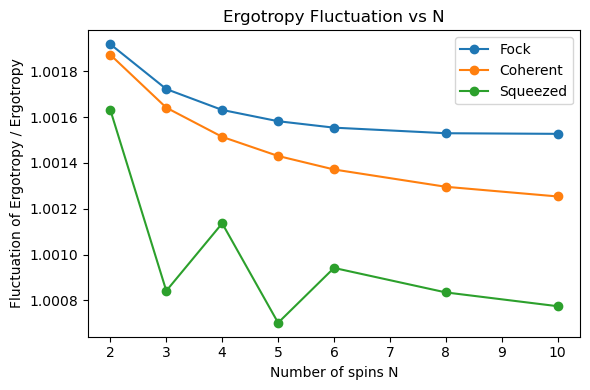

In [160]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# ------------------------------
# Ergotropy and variance via passive state
# ------------------------------
def passive_state(rho, H):
    r_vals, r_vecs = rho.eigenstates()
    r_vals = np.sort(r_vals)[::-1]  # descending
    E_vals, E_vecs = H.eigenstates()  # ascending
    rho_pass = sum(r_vals[i] * E_vecs[i]*E_vecs[i].dag() for i in range(len(r_vals)))
    return rho_pass

def ergotropy_and_var(rho, HB):
    rho_pass = passive_state(rho, HB)
    erg = qt.expect(HB, rho) - qt.expect(HB, rho_pass)
    
    # variance of ergotropy
    delta_H = HB - qt.expect(HB, rho_pass) * qt.qeye(HB.shape[0])
    var = qt.expect(delta_H**2, rho)
    return erg, var

# ------------------------------
# Simulate N
# ------------------------------
def simulate_N(N, state_type, w0=1.0, g=1.0):
    j = N / 2
    M = N + 6

    # Operators (Dicke basis)
    a  = qt.tensor(qt.destroy(M), qt.qeye(int(2*j+1)))
    Jp = qt.tensor(qt.qeye(M), qt.jmat(j, '+'))
    Jm = qt.tensor(qt.qeye(M), qt.jmat(j, '-'))
    Jz = qt.tensor(qt.qeye(M), qt.jmat(j, 'z'))

    HA = w0 * a.dag() * a
    HB_full = w0 * (j + Jz)
    H = HA + HB_full + g * (a*Jp + a.dag()*Jm)

    HB = w0 * (j + qt.jmat(j, 'z'))

    # Initial battery state
    psiA = {
        "fock":      qt.basis(M, N),
        "coherent":  qt.coherent(M, np.sqrt(N)),
        "squeezed":  qt.squeeze(M, np.arcsinh(np.sqrt(N))) * qt.basis(M, 0)
    }[state_type]

    psi0 = qt.tensor(psiA, qt.basis(int(2*j+1), 0))

    # Optimize charging time by maximizing instantaneous power
    taus = np.linspace(0.05, 5/np.sqrt(N), 30)
    powers = []
    for t in taus:
        rho = qt.mesolve(H, psi0, [0, t]).states[-1]
        rhoB = rho.ptrace(1)
        powers.append(qt.expect(HB, rhoB)/t)
    tbar = taus[np.argmax(powers)]

    # Final state at optimal time
    rho = qt.mesolve(H, psi0, [0, tbar]).states[-1]
    rhoB = rho.ptrace(1)

    # Ergotropy and variance
    erg, var = ergotropy_and_var(rhoB, HB)
    EB = qt.expect(HB, rhoB)
    EPS = 1e-12
    return erg/EB, np.sqrt(var)/(erg + EPS)  # mean_ratio, fluctuation_ratio

# ------------------------------
# Run simulation for multiple N
# ------------------------------
Ns = np.array([2, 3, 4, 5, 6, 8, 10])
states = ["fock", "coherent", "squeezed"]

mean_ratios = {s: [] for s in states}
fluct_ratios = {s: [] for s in states}

for s in states:
    for N in Ns:
        m, f = simulate_N(N, s)
        mean_ratios[s].append(m)
        fluct_ratios[s].append(f)

# ------------------------------
# Plot 1: Ergotropy / Battery Energy
# ------------------------------
plt.figure(figsize=(6,4))
for s in states:
    plt.plot(Ns, mean_ratios[s], marker='o', label=s.capitalize())
plt.xlabel("Number of spins N")
plt.ylabel(r"$\mathcal{E}_B / E_B$")
plt.title("Ergotropy vs N")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# Plot 2: Fluctuation / Ergotropy
# ------------------------------
plt.figure(figsize=(6,4))
for s in states:
    plt.plot(Ns, fluct_ratios[s], marker='o', label=s.capitalize())
plt.xlabel("Number of spins N")
plt.ylabel(r"Fluctuation of Ergotropy / Ergotropy")
plt.title("Ergotropy Fluctuation vs N")
plt.legend()
plt.tight_layout()
plt.show()


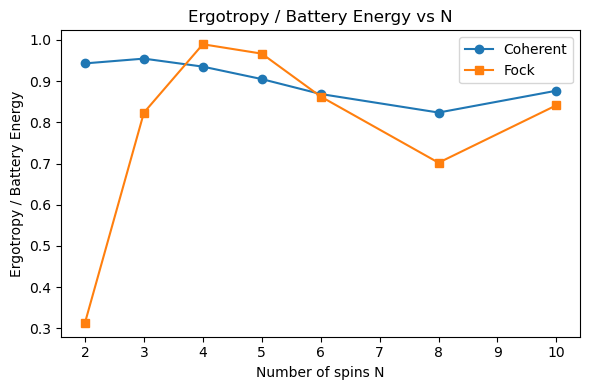

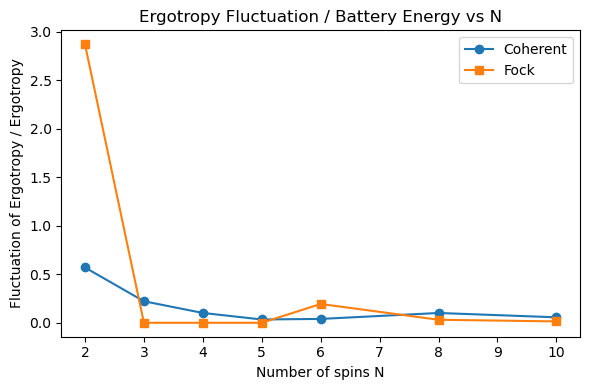

In [161]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

################
# Passive state
################
def passive_state(rho, H):
    r = np.sort(rho.eigenenergies())[::-1]
    E, evecs = H.eigenstates()
    return sum(r[i] * evecs[i] * evecs[i].dag() for i in range(len(r)))

# -------------------------
# Truncated ergotropy variance
# -------------------------
def ergotropy_variance_truncated(rho, H, cutoff=1e-10):
    r, rvecs = rho.eigenstates()
    idx = np.argsort(r)[::-1]

    E, evecs = H.eigenstates()

    keep = [i for i in idx if r[i] > cutoff]

    mean = 0.0
    mean2 = 0.0

    for i in keep:
        for j in keep:
            overlap = abs(evecs[j].overlap(rvecs[i]))**2
            p = r[i] * overlap
            dE = E[j] - E[i]
            mean += p * dE
            mean2 += p * dE**2

    return mean2 - mean**2, mean  # return variance and ergotropy

# -------------------------
# Tavis–Cummings simulation
# -------------------------
def simulate_fast(N, state="coherent", nmax=20, t=1.2):
    a = qt.destroy(nmax)
    sp, sm, I = qt.sigmap(), qt.sigmam(), qt.qeye(2)

    Sp = sum(qt.tensor([sp if i == k else I for i in range(N)])
             for k in range(N))
    Sm = Sp.dag()

    HB = sum(qt.tensor([sp*sm if i == k else I for i in range(N)])
             for k in range(N))

    IB = qt.tensor([qt.qeye(2)] * N)

    H = (qt.tensor(a.dag()*a, IB)
         + qt.tensor(qt.qeye(nmax), HB)
         + qt.tensor(a, Sp)
         + qt.tensor(a.dag(), Sm))

    psiA = qt.coherent(nmax, np.sqrt(N)) if state == "coherent" \
           else qt.basis(nmax, N)

    psiB = qt.tensor([qt.basis(2, 0)] * N)
    psi0 = qt.tensor(psiA, psiB)

    rhoB = qt.mesolve(H, psi0, [0, t]).states[-1] \
              .ptrace(list(range(1, N+1)))

    EB = qt.expect(HB, rhoB)

    rho_p = passive_state(rhoB, HB)
    erg = EB - qt.expect(HB, rho_p)

    var_erg, _ = ergotropy_variance_truncated(rhoB, HB)
    
    fluct_ratio = np.sqrt(var_erg) / (erg + 1e-12)  # fluctuation / ergotropy
    mean_ratio = erg / (EB + 1e-12)                # ergotropy / battery energy

    return mean_ratio, fluct_ratio

# -------------------------
# Run
# -------------------------
Ns = [2, 3, 4, 5, 6, 8, 10]

mc, fc = [], []  # coherent: mean_ratio, fluctuation
mf, ff = [], []  # fock: mean_ratio, fluctuation

for N in Ns:
    m, f = simulate_fast(N, "coherent")
    mc.append(m); fc.append(f)

    m, f = simulate_fast(N, "fock")
    mf.append(m); ff.append(f)

# -------------------------
# Plot 1: Ergotropy / Battery Energy vs N
# -------------------------
plt.figure(figsize=(6,4))
plt.plot(Ns, mc, "o-", label="Coherent")
plt.plot(Ns, mf, "s-", label="Fock")
plt.xlabel("Number of spins N")
plt.ylabel("Ergotropy / Battery Energy")
plt.title("Ergotropy / Battery Energy vs N")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Plot 2: Fluctuation / Ergotropy vs N
# -------------------------
plt.figure(figsize=(6,4))
plt.plot(Ns, fc, "o-", label="Coherent")
plt.plot(Ns, ff, "s-", label="Fock")
plt.xlabel("Number of spins N")
plt.ylabel("Fluctuation of Ergotropy / Ergotropy")
plt.title("Ergotropy Fluctuation / Battery Energy vs N")
plt.legend()
plt.tight_layout()
plt.show()


In [162]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# ------------------------------
# Collective operators and battery
# ------------------------------
def collective_ops(N):
    sp, sm, I = qt.sigmap(), qt.sigmam(), qt.qeye(2)
    Sp = sum(qt.tensor([sp if i==k else I for i in range(N)]) for k in range(N))
    Sm = Sp.dag()
    HB = sum(qt.tensor([sp*sm if i==k else I for i in range(N)]) for k in range(N))
    return Sp, Sm, HB

# ------------------------------
# Tavis-Cummings Hamiltonian
# ------------------------------
def tavis_cummings(N, nmax, ω=1.0, ω0=1.0, g=1.0):
    a = qt.destroy(nmax)
    Sp, Sm, HB = collective_ops(N)
    IB = qt.tensor([qt.qeye(2)]*N)
    H = ω * qt.tensor(a.dag()*a, IB) + ω0 * qt.tensor(qt.qeye(nmax), HB) + g * (qt.tensor(a, Sp) + qt.tensor(a.dag(), Sm))
    return H, HB

# ------------------------------
# Initial state
# ------------------------------
def initial_state(N, nmax, state):
    if state=="coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif state=="fock":
        psiA = qt.basis(nmax, N)
    psiB = qt.tensor([qt.basis(2,0)]*N)
    return qt.tensor(psiA, psiB)

# ------------------------------
# Passive state
# ------------------------------
def passive_state(rho, H):
    r = np.sort(rho.eigenenergies())[::-1]  # descending
    E, evecs = H.eigenstates()               # ascending
    rho_pass = sum(r[i]*evecs[i]*evecs[i].dag() for i in range(len(r)))
    return rho_pass

# ------------------------------
# Energy projectors
# ------------------------------
def energy_projectors(H):
    E, vecs = H.eigenstates()
    projectors = [v*v.dag() for v in vecs]
    return E, projectors

# ------------------------------
# Build pnm matrix
# ------------------------------
def pnm_matrix(rhoB, HB):
    rho_pass = passive_state(rhoB, HB)
    E, proj = energy_projectors(HB)
    dim = len(E)
    pnm = np.zeros((dim, dim))
    for n in range(dim):
        for m in range(dim):
            pnm[n,m] = (proj[n] * rho_pass * proj[m]).tr().real
    return pnm, np.array(E)

# ------------------------------
# Ergotropy and fluctuation via pnm matrix
# ------------------------------
def erg_pnm(rhoB, HB):
    pnm, E = pnm_matrix(rhoB, HB)
    delta_E = E[None,:] - E[:,None]
    erg = np.sum(delta_E * pnm)
    erg_var = np.sum((delta_E**2) * pnm) - erg**2
    return erg, erg_var

# ------------------------------
# Optimal charging time
# ------------------------------
def optimal_time(H, HB, psi0, N, tmax=5.0):
    def minus_erg(t):
        rho = qt.mesolve(H, psi0, [0, t]).states[-1]
        rhoB = rho.ptrace(list(range(1, N+1)))
        erg, _ = erg_pnm(rhoB, HB)
        return -erg
    res = minimize_scalar(minus_erg, bounds=(0.05, tmax), method='bounded')
    return res.x

# ------------------------------
# Full simulation
# ------------------------------
EPS = 1e-12  # small number to prevent division by zero

def simulate(N, state, nmax=20, ω=1.0, ω0=1.0, g=1.0):
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    psi0 = initial_state(N, nmax, state)
    t_opt = optimal_time(H, HB, psi0, N)
    rho = qt.mesolve(H, psi0, [0, t_opt]).states[-1]
    rhoB = rho.ptrace(list(range(1, N+1)))
    EB = qt.expect(HB, rhoB)
    erg, var = erg_pnm(rhoB, HB)
    
    # Avoid division by zero
    mean_ratio = erg/(EB + EPS)
    fluct_ratio = np.sqrt(var)/(erg + EPS)
    return mean_ratio, fluct_ratio, t_opt


# ------------------------------
# Run simulation and plot
# ------------------------------
Ns = [2, 3, 4, 5, 6]
mc, fc = [], []  # mean and fluctuation for coherent
mf, ff = [], []  # mean and fluctuation for fock

ω, ω0, g = 1.0, 1.0, 1.0
nmax = 20

for N in Ns:
    m, f, _ = simulate(N, "coherent", nmax, ω, ω0, g)
    mc.append(m); fc.append(f)
    m, f, _ = simulate(N, "fock", nmax, ω, ω0, g)
    mf.append(m); ff.append(f)

# Plot 1: Ergotropy / Battery Energy vs N
plt.figure(figsize=(6,4))
plt.plot(Ns, mc, "o-", label="Coherent")
plt.plot(Ns, mf, "s-", label="Fock")
plt.xlabel("Number of spins N")
plt.ylabel("⟨Ergotropy⟩ / Battery Energy")
plt.title("Ergotropy vs N")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Fluctuation / Ergotropy vs N
plt.figure(figsize=(6,4))
plt.plot(Ns, fc, "o-", label="Coherent")
plt.plot(Ns, ff, "s-", label="Fock")
plt.xlabel("Number of spins N")
plt.ylabel("Fluctuation of Ergotropy / Ergotropy")
plt.title("Ergotropy Fluctuation vs N")
plt.legend()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [32]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

############
# parameters
############

N_arr = np.arange(2, 20, 2)
nmax = 20
ω = 1.0
ω0 = 1.0
g = 1.0
tlist = np.arange(0.01, (2*np.pi), 0.1)

######################
# collective operators
######################

def collective_ops(N):
    sp, sm, I = qt.sigmap(), qt.sigmam(), qt.qeye(2)
    Sp = qt.jmat(N/2,'+')
    Sm = Sp.dag()
    Sz = qt.jmat(N/2,'z')
    HB = Sz+N/2*qt.qeye(N+1)
    return Sp, Sm, HB

############################
# Tavis-Cummings Hamiltonian
############################

def tavis_cummings(N, nmax, ω, ω0, g):
    a = qt.destroy(nmax)
    Sp, Sm, HB = collective_ops(N)
    IB = qt.qeye(N+1)
    H = (ω * qt.tensor(a.dag()*a, IB) + ω0 * qt.tensor(qt.qeye(nmax), HB) + g * (qt.tensor(a, Sp) + qt.tensor(a.dag(), Sm)))

    return H, HB

################
# Passive state
################

def passive_state(rho, H):
    r_val, r_vec = rho.eigenstates()
    idx = np.argsort(r_val)[::-1]          # decending order
    r_val = r_val[idx]

    e_val, e_vec = H.eigenstates()          # ascending order

    return sum(r_val[i] * e_vec[i] * e_vec[i].dag()
               for i in range(len(r_val)))

    
########################
# ergotropy calculation
########################

def ergotropy(ρ, H):
    ρ_p = passive_state(ρ, H)
    return qt.expect(H, ρ) - qt.expect(H, ρ_p)


################
# Initial state
################

def initial_state(N, nmax, state):
    if state=="coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif state=="fock":
        psiA = qt.basis(nmax, N)
    psiB = qt.basis(N+1, 0)  
    return qt.tensor(psiA, psiB)


##############
# Pnm matrix
##############

def pnm_matrix(rho, H):
    r_val, r_vec = rho.eigenstates()
    idx = np.argsort(r_val)[::-1]
    r_val = r_val[idx]
    r_vec = [r_vec[i] for i in idx]

    e_val, e_vec = H.eigenstates()

    dim = len(e_val)
    pnm = np.zeros((dim, dim))

    for m in range(dim):
        for n in range(dim):
            pnm[n, m] = abs(e_vec[n].overlap(r_vec[m]))**2

    return pnm, r_val, e_val



############################
# ergotropy using pnm matrix
############################

def ergotropy_pnm(pnm, r_val, e_val):
    deltaE = e_val[:,None] - e_val[None,:]
    return np.sum(r_val[None,:] * pnm * deltaE)



############################
# variance using pnm matrix
############################

def variance_pnm(pnm, r_val, e_val):
    deltaE2 = (e_val[:,None] - e_val[None,:])**2
    mean2 = np.sum(r_val[None,:] * pnm * deltaE2)
    mean = ergotropy_pnm(pnm, r_val, e_val)
    return mean2 - mean**2

########################
# Calculating Ergotropy
########################

erg_list = []
for N_idx, N in enumerate(N_arr):
    E = N * ω # Energy in the charger
    erg_list1 = []
    τ = τ_list[N_idx]
    H = TC_fun(ω, ω0, j, M, g)
    Hb = Hb_fun(ω0, j, M)
    ψ0 = fock_state_fun(E, M, ω, j)
    result = qt.sesolve(H, ψ0, [0, τ])
    ψτ = result.states[-1]
    ρτ = qt.ket2dm(ψτ)
    ρbτ = qt.ptrace(ρτ, 1)
    erg = erg_fun(ρbτ, Hb)
    Eb = (Hb*ρbτ).tr()
    erg_list.append(erg/Eb)

###############################################
# Plot erg as function of g for different N 
###############################################

plt.plot(N_arr, erg_list, marker=".")
plt.xlabel(fr"Spins $N$")
plt.ylabel(r"$\mathcal{E}/E_b$")
plt.ylim(-0.05,1.05)
plt.show()